In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *
from thesispy.elastix_wrapper.runner import run
from thesispy.elastix_wrapper.parameters import Parameters
from thesispy.experiments.instance import read_controlpoints, read_transform_params
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
import numpy as np

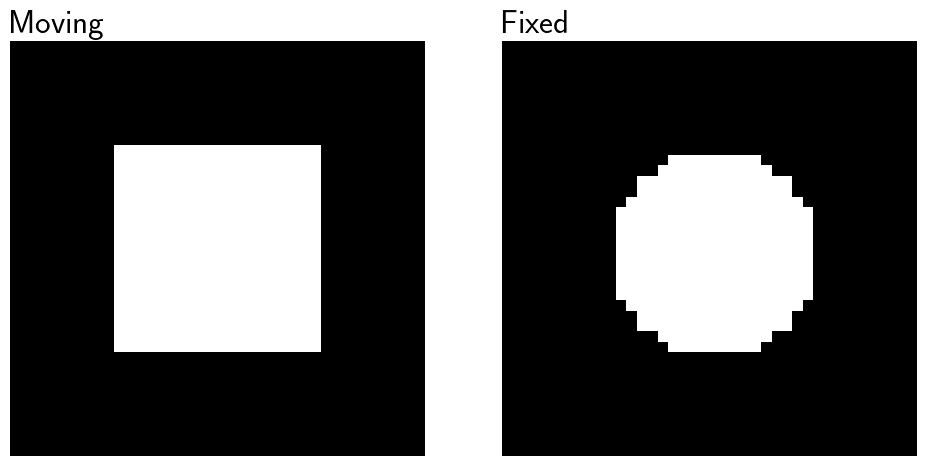

In [3]:
moving_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Moving.png")
fixed_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Fixed.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(moving_img, cmap="gray")
axes[0].set_title("Moving", fontsize=24)
axes[0].axis("off")

axes[1].imshow(fixed_img, cmap="gray")
axes[1].set_title("Fixed", fontsize=24)
axes[1].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("trivial_registration.pdf", bbox_inches="tight")

In [5]:
params = Parameters.from_base(mesh_size=5).asgd().stopping_criteria(iterations=10000).instance(Collection.EXAMPLES, 1)
run_result = run(params, Path("output/" + str(params)), suppress_stdout=False, visualize=False, validate=False)

2023-03-28 23:15:38,811 - Runner - INFO - Running elastix in: output/1680038138_examples_1_adaptivestochasticgradientdescent_811286



elastix is started at Tue Mar 28 23:15:38 2023.

which elastix:   /home/joasiee/Documents/projects/elastix/build/Release/bin/elastix
  elastix version: 5.1.0
  Git revision SHA: 7f2f1ae53f85723288a02efad588f9e1209ab154
  Git revision date: Fri Mar 24 13:17:05 2023 +0100
  Build date: Mar 28 2023 23:07:25
  Compiler: GCC version 12.2.1 20230201
  Memory address size: 64-bit
  CMake version: 3.26.1
  ITK version: 5.3.0

Command-line arguments: 
  -p output/1680038138_examples_1_adaptivestochasticgradientdescent_811286/params_1.txt -f /home/joasiee/Documents/projects/instances/examples/scans/01_Fixed.png -m /home/joasiee/Documents/projects/instances/examples/scans/01_Moving.png -out output/1680038138_examples_1_adaptivestochasticgradientdescent_811286/out -threads 6

elastix runs at: archlinux
  Linux 6.1.21-1-lts (x64), #1 SMP PREEMPT_DYNAMIC Wed, 22 Mar 2023 14:30:48 +0000
  with 31842 MB memory, and 10 cores @ 4500 MHz.
-----------------------------------------------------------------

2023-03-28 23:15:39,800 - Runner - INFO - Run ended. It took 0.9891 seconds


9103	0.083005	70.562500	156.770000	0.594283	14.569600	0.017877	0.1
9104	0.083025	70.562500	157.770000	0.590959	14.571200	0.004693	0.1
9105	0.083013	70.562500	158.770000	0.587672	14.572800	0.003956	0.1
9106	0.083004	70.562500	158.760000	0.587704	14.574400	0.003456	0.1
9107	0.082998	70.562500	158.750000	0.587737	14.576000	0.003118	0.1
9108	0.082992	70.562500	158.740000	0.587770	14.577600	0.002890	0.1
9109	0.082987	70.562500	158.730000	0.587802	14.579200	0.002736	0.1
9110	0.082983	70.562500	158.720000	0.587835	14.580800	0.002630	0.1
9111	0.082979	70.562500	158.710000	0.587868	14.582400	0.002557	0.1
9112	0.082976	70.562500	158.700000	0.587900	14.584000	0.017855	0.1
9113	0.082998	70.562500	159.700000	0.584647	14.585600	0.004682	0.1
9114	0.082986	70.562500	160.700000	0.581429	14.587200	0.003957	0.1
9115	0.082978	70.562500	160.690000	0.581461	14.588800	0.003463	0.1
9116	0.082971	70.562500	160.680000	0.581493	14.590400	0.003127	0.1
9117	0.082966	70.562500	160.670000	0.581525	14.592000	0.002900

<Figure size 700x700 with 0 Axes>

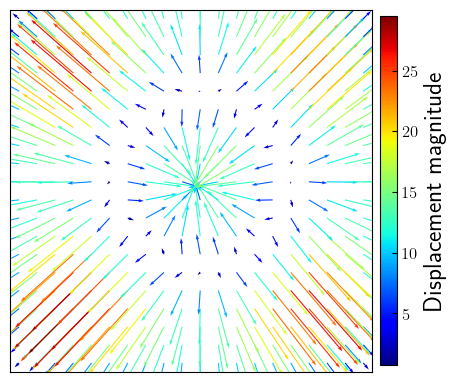

In [18]:
from thesispy.experiments.validation import *

# matplotlib change rc param
plt.rcParams["axes.labelsize"] = 18

plt.figure(figsize=(7, 7))
plot_dvf(run_result.dvf[::2, ::2], scale=6)
plt.savefig("trivial_dvf.pdf", bbox_inches="tight")

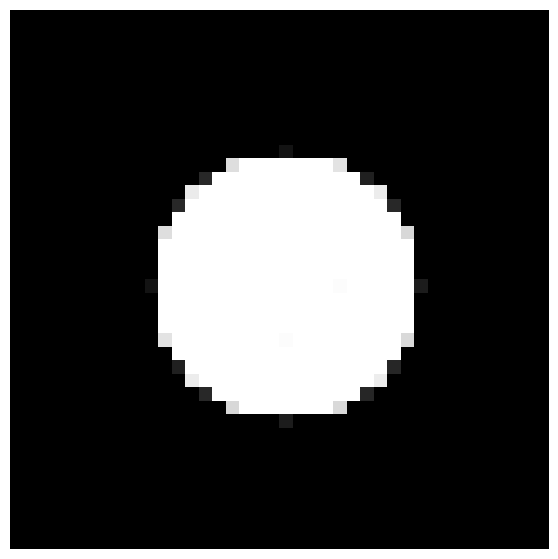

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(run_result.deformed, cmap="gray")
plt.axis("off")
plt.savefig("trivial_deformed.pdf", bbox_inches="tight")

In [20]:
iteration_output = np.loadtxt(Path("output") / "1679494920_examples_1_adaptivestochasticgradientdescent_266805" / "out" / "IterationInfo.0.R0.txt", skiprows=1)
missed_pixels = iteration_output[:, 2]

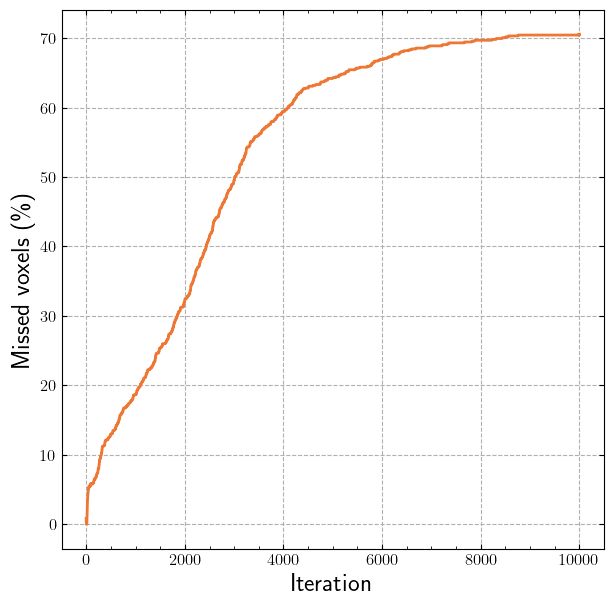

In [21]:
from thesispy.plot_utils import *

plt.figure(figsize=(7, 7))
plt.plot(missed_pixels)
plt.xlabel("Iteration")
plt.ylabel("Missed voxels (\%)")

plt.savefig("trivial_missedvoxels.pdf", bbox_inches="tight")

In [2]:
ds = get_runs_as_dataset("synthetic_1_constrained_selection")
ds.save()

In [3]:
arrs = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"])
arrs_mp = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"], metric="missedpixels")

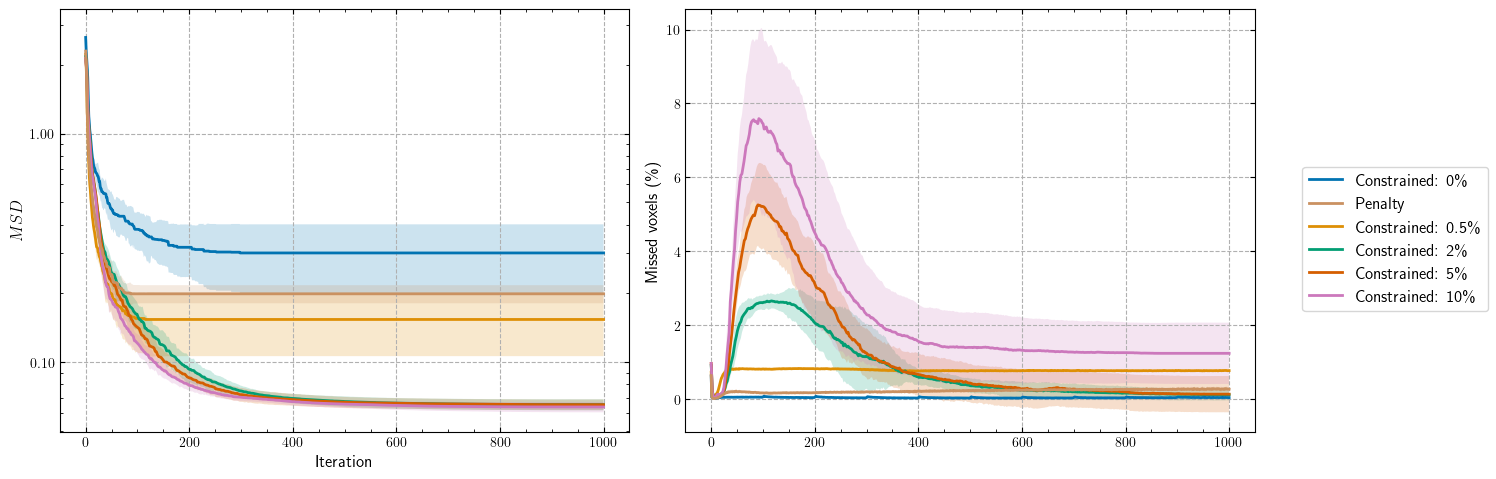

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for use_constraints in [True, False]:
    for i, constraints_threshold in enumerate([0, 0.5, 2, 5, 10]):
        if not use_constraints and i > 0:
            continue

        arr_avg, arr_median, arr_std = arrs[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        label = f"Constrained: {constraints_threshold}\%" if use_constraints else "Penalty"
        axes[0].plot(xs, arr_median, label=label)
        axes[0].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)

        arr_avg, arr_median, arr_std = arrs_mp[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        axes[1].plot(xs, arr_median, label=label)
        axes[1].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
    
        # formatting
        axes[0].set_yscale("log")
        axes[0].yaxis.set_major_formatter(formatter)
        axes[0].set_xlabel("Iteration", fontsize=12)
        axes[0].set_ylabel("$MSD$", fontsize=12)
        axes[1].set_ylabel("Missed voxels (\%)", fontsize=12)


handles, labels = axes[0].get_legend_handles_labels()
order = [0, 5, 1, 2, 3, 4]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(handles, labels, ncol=1, loc="center right", prop={'size': 12})
plt.tight_layout(rect=[0, 0.02, 0.85, 1])
# plt.savefig("constrained_selection_iterations.pdf")

In [ ]:
out_dir = Path('output/missed_pixels/out/')
files = [f for f in sorted((out_dir / "controlpoints.R0").iterdir(), key=lambda m: int(m.stem.split('.')[0])) if f.is_file()]
_, grid_spacing, grid_origin = read_transform_params(out_dir / 'TransformParameters.0.txt')

In [ ]:
def plot_cpoints(
    points,
    grid_spacing,
    grid_origin,
    alpha=0.8,
    color='red',
    plot_init=True,
    slice=None,
    ax=None,
):
    points_slice = points
    if len(points.shape) == 4:
        if slice is None:
            slice = points.shape[2] // 2
        points_slice = points[:, :, slice, :]

    grid_spacing = np.array(grid_spacing)
    grid_origin = np.array(grid_origin)

    grid_origin = grid_origin + 0.5
    X, Y = np.meshgrid(
        *[
            np.arange(
                grid_origin[i],
                grid_origin[i] + grid_spacing[i] * points_slice.shape[i],
                grid_spacing[i],
            )
            for i in range(len(points_slice.shape[:-1]))
        ]
    )

    colormap_colors = ["red", "green", "blue", "black"]
    cmap = LinearSegmentedColormap.from_list("quadrants", colormap_colors)

    colors = np.zeros(points_slice.shape[:-1])
    levels = int(np.ceil(points_slice.shape[0] / 2))
    for level in range(levels):
        level_color = (level+1) / levels
        max_index = points_slice.shape[0]-1-level
        colors[level, level:max_index+1] = level_color
        colors[max_index, level:max_index+1] = level_color
        colors[level:max_index+1, level] = level_color
        colors[level:max_index+1, max_index] = level_color

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca()

    if plot_init:
        ax.scatter(Y, X, marker="+", c=colors, cmap=cmap, alpha=0.5, s=20)

    ax.grid(False)
    ax.scatter(
        points_slice[..., 0],
        points_slice[..., 1],
        marker="s",
        s=15,
        c=colors,
        cmap=cmap,
        alpha=alpha,
    )

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_intervals = [0, 10, 100, 300]
n_intervals = len(plot_intervals)

for n, i in enumerate(plot_intervals):
    cpoints = read_controlpoints(files[i])
    plot_cpoints(cpoints, grid_spacing, grid_origin, ax=axes[n])
    axes[n].set_xticks([])
    axes[n].set_yticks([])
    axes[n].set_title(f"Generation = {i}", fontsize=14)
    axes[n].set_aspect('equal')

plt.tight_layout()
plt.savefig("missedpixels_controlpoints.pdf")

In [2]:
from thesispy.experiments.wandb_client import get_run_result

run_result_0 = get_run_result("synthetic_1_constrained_selection", "3hp1vybk")
run_result_10 = get_run_result("synthetic_1_constrained_selection", "y15mwrmb")

2023-03-16 12:56:23,050 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_constrained_selection/3hp1vybk
2023-03-16 12:56:25,913 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_constrained_selection/y15mwrmb


In [3]:
from thesispy.experiments.validation import plot_voxels, plot_dvf, get_vmin_vmax

clim_dvf, clim_jac = get_vmin_vmax(run_result_0, run_result_10)

2023-03-16 12:56:29,269 - Validation - INFO - Jacobian min,max: -0.1341476660895775, 6.709217035144078
2023-03-16 12:56:29,271 - Validation - INFO - Jacobian min,max: -1.830004321789985, 6.64560898184032


In [4]:
plot_dvf(run_result_0.dvf, vmin=clim_dvf[0], vmax=clim_dvf[1])
plt.savefig("dvf_c0.pdf", bbox_inches='tight')

In [5]:
plot_dvf(run_result_10.dvf, vmin=clim_dvf[0], vmax=clim_dvf[1])
plt.savefig("dvf_c10.pdf", bbox_inches='tight')

In [6]:
plot_voxels(run_result_0.deformed)
plt.savefig("voxels_constrained_0.pdf", bbox_inches='tight')

In [7]:
plot_voxels(run_result_10.deformed)
plt.savefig("voxels_constrained_10.pdf", bbox_inches='tight')